## <center>Exercise - DCGANs</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Conv2DTranspose, Reshape, LeakyReLU, Dropout, UpSampling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

#### Data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
only_zeros = X_train[y_train==0]
only_zeros_test = X_test[y_test==0]

#### Data visualization

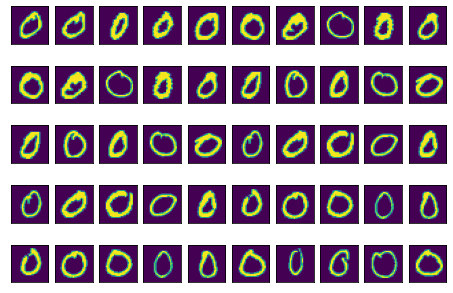

<Figure size 360x720 with 0 Axes>

In [3]:
fig, ax = plt.subplots(5, 10)
plt.figure(figsize=(5, 10))
fig.tight_layout(pad=-1)

for i in range(5):
    for j in range(10):
        ax[i,j].imshow(only_zeros[5*i+j])
        ax[i, j].xaxis.set_visible(False)
        ax[i, j].yaxis.set_visible(False)


#### Reshape and rescale

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(only_zeros.reshape(-1, 28*28))
X_test = scaler.transform(only_zeros_test.reshape(-1,28*28))

X_train = X_train.reshape(-1, 28,28,1)
X_test = X_test.reshape(-1,28,28,1)

### Building the model

#### Generator

In [5]:
def gen():
    
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2DTranspose(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2DTranspose(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [6]:
generator = gen()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0

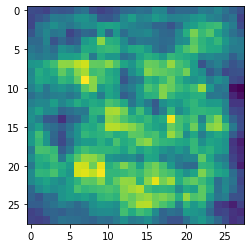

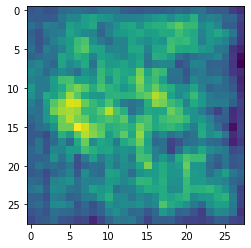

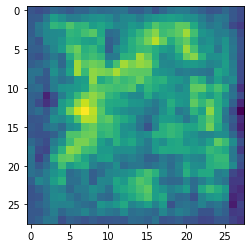

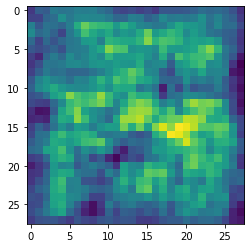

In [7]:
# Create a random noise and generate a sample
noise = tf.random.normal([4, 128])
generated_image = generator(noise, training=False)
# Visualize the generated sample

for i in range(4):
    plt.imshow(generated_image[i])
    plt.show()

#### Discriminator

In [8]:
def disc():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [9]:
discriminator = disc()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)      

In [10]:
discriminator.predict(generated_image) # Not trained, can't know if true or fake, predicts in between --> 0.5

1/1 [==============================] - 0s 150ms/step


array([[0.49532485],
       [0.49542508],
       [0.49536368],
       [0.49536481]], dtype=float32)

### Configure the GAN Network

#### Loss Function

In [11]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### Building the subclassed model

In [12]:
batch_size = 32
my_data = only_zeros

dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [13]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 
    
    def train_step(self, batch):

        # Get data
        real_images = batch
        fake_images = self.generator(tf.random.normal(shape=[batch_size, 128]), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:

            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal(shape=[batch_size, 128]), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [14]:
# Create instance of subclassed model
gan = GAN(generator, discriminator)

# Compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [15]:
hist = gan.fit(dataset, epochs=20)

Epoch 1/20
185/185 [==============================] - 465s 3s/step - d_loss: 1.0537 - g_loss: 0.5981
Epoch 2/20
185/185 [==============================] - 601s 3s/step - d_loss: 0.9856 - g_loss: 0.6497
Epoch 3/20
185/185 [==============================] - 714s 4s/step - d_loss: 0.9506 - g_loss: 0.6952
Epoch 4/20
185/185 [==============================] - 732s 4s/step - d_loss: 0.9412 - g_loss: 0.7296
Epoch 5/20
185/185 [==============================] - 774s 4s/step - d_loss: 0.9122 - g_loss: 0.7768
Epoch 6/20
185/185 [==============================] - 800s 4s/step - d_loss: 0.8960 - g_loss: 0.8213
Epoch 7/20
185/185 [==============================] - 853s 5s/step - d_loss: 0.8786 - g_loss: 0.8886
Epoch 8/20
185/185 [==============================] - 839s 5s/step - d_loss: 0.8538 - g_loss: 0.9894
Epoch 9/20
185/185 [==============================] - 762s 4s/step - d_loss: 0.8290 - g_loss: 1.1439
Epoch 10/20
185/185 [==============================] - 755s 4s/step - d_loss: 0.7978 - g_lo

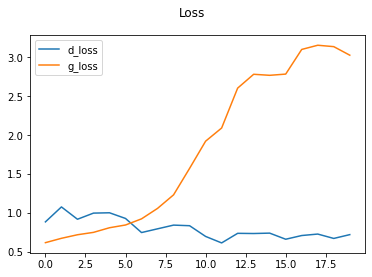

In [16]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 470ms/step


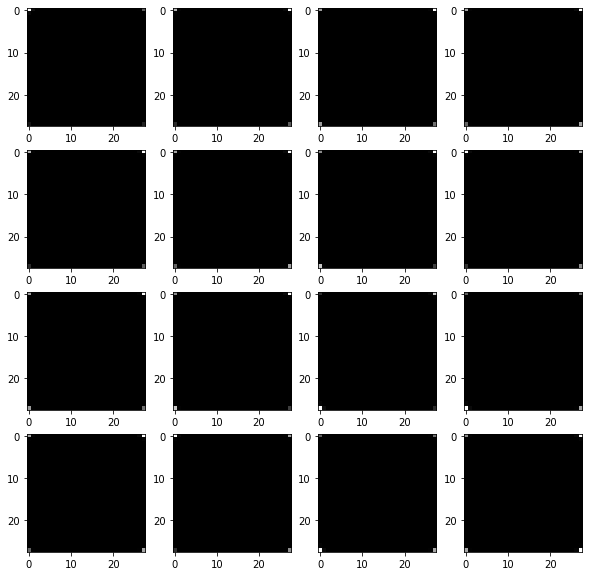

In [17]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1], cmap="Greys")